In [1]:
import pandas as pd
import re,string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from xgboost.sklearn import XGBClassifier

In [2]:
data = pd.read_csv('/kaggle/input/fake-reviews/fake reviews dataset.csv')

In [3]:
data.drop('category', inplace=True, axis=1)

In [4]:
data.label=data.label.apply(lambda x: 0 if x=='CG' else 1)

data.head()

,rating,label,text_
0,5.0,0,"Love this! Well made, sturdy, and very comfor..."
1,5.0,0,"love it, a great upgrade from the original. I..."
2,5.0,0,This pillow saved my back. I love the look and...
3,1.0,0,"Missing information on how to use it, but it i..."
4,5.0,0,Very nice set. Good quality. We have had the s...


In [5]:
array = np.load('/kaggle/input/label-encoded-value/my_array.npy', allow_pickle=True)

In [6]:
VOCAB_SIZE=25000

max_index = 1592

In [7]:
X1=array
y1=data['label']

In [8]:
y2=np.array(y1)
y2

array([0, 0, 0, ..., 1, 0, 1])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X1,y2, test_size=0.2,random_state=42)

In [10]:
max_train_length = max (len(review) for review in X_train )
max_test_length = max (len(review) for review in X_test)

In [11]:
max_length = max(max_train_length, max_test_length)
print("Maximum length of a review in dataset:", max_length)

Maximum length of a review in dataset: 240


In [12]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [13]:
from keras_preprocessing.sequence import pad_sequences

# Pad each review in the dataset till their length = max_length
print("Padding the reviews...")
X_train = pad_sequences (X_train, maxlen=max_length)
X_test = pad_sequences (X_test, maxlen=max_length)

print("Shape of train_data =", X_train.shape)
print("Shape of test_data  =", X_test.shape)

Padding the reviews...
Shape of train_data = (32345, 240)
Shape of test_data  = (8087, 240)


In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=50000, output_dim=32, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=64, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 240, 32)           1600000   
                                                                 
 conv1d (Conv1D)             (None, 240, 64)           6208      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 120, 64)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,639,297
Trainable params: 1,639,297
Non-trainable params: 0
______________________________________________

In [15]:
import tensorflow as tf

In [16]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_CNNmodel_RNN.hdf5',
                     monitor = 'val_acc',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),

                 EarlyStopping(
                    monitor = 'val_acc',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0
                 ),

                 TerminateOnNaN()
]

In [18]:
history = model.fit(X_train,y_train,epochs = 45,batch_size = 32,verbose = 1,callbacks = callback_list,validation_split = 0.02,shuffle = True)

Epoch 1/45
991/991 [==============================] - ETA: 0s - loss: 0.3300 - acc: 0.8544
Epoch 1: val_acc improved from -inf to 0.88253, saving model to ./best_CNNmodel_RNN.hdf5
991/991 [==============================] - 148s 145ms/step - loss: 0.3300 - acc: 0.8544 - val_loss: 0.2835 - val_acc: 0.8825 - lr: 0.0100
Epoch 2/45
991/991 [==============================] - ETA: 0s - loss: 0.2050 - acc: 0.9182
Epoch 2: val_acc improved from 0.88253 to 0.90572, saving model to ./best_CNNmodel_RNN.hdf5
991/991 [==============================] - 143s 144ms/step - loss: 0.2050 - acc: 0.9182 - val_loss: 0.2347 - val_acc: 0.9057 - lr: 0.0100
Epoch 3/45
991/991 [==============================] - ETA: 0s - loss: 0.1624 - acc: 0.9372
Epoch 3: val_acc did not improve from 0.90572
991/991 [==============================] - 143s 145ms/step - loss: 0.1624 - acc: 0.9372 - val_loss: 0.2586 - val_acc: 0.8995 - lr: 0.0100
Epoch 4/45
991/991 [==============================] - ETA: 0s - loss: 0.1374 - acc: 0.

In [19]:
print("Best Validation Accuracy =", max(history.history['val_acc'])*100)
print("Best Training Accuracy =", max(history.history['acc'])*100)

Best Validation Accuracy = 91.80834889411926
Best Training Accuracy = 99.62142705917358


In [20]:
print("Best Validation Accuracy =", max(history.history['val_acc'])*100)
print("Best Training Accuracy =", max(history.history['acc'])*100)

Best Validation Accuracy = 91.80834889411926
Best Training Accuracy = 99.62142705917358


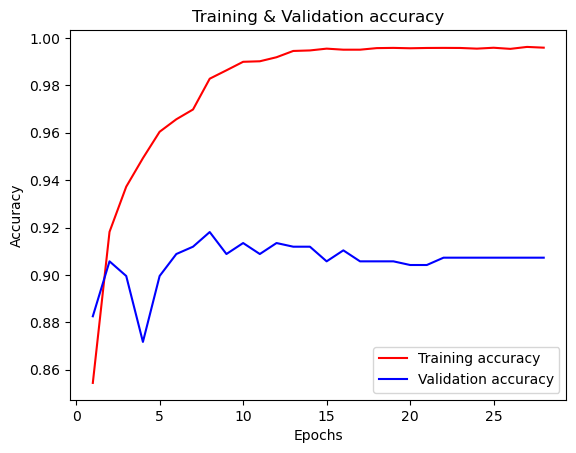

In [21]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

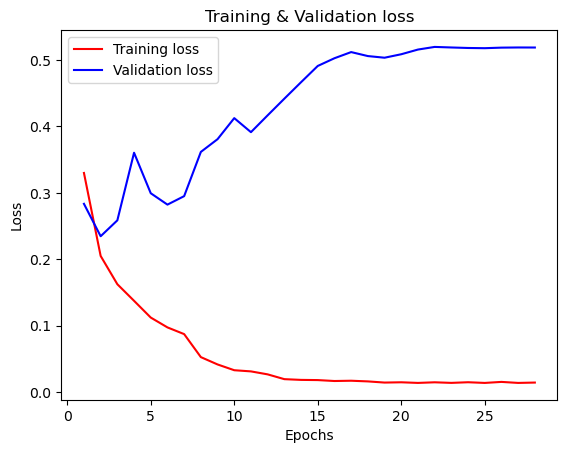

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
test_metrics = model.evaluate(X_test, y_test)

253/253 [==============================] - 5s 21ms/step - loss: 0.3171 - acc: 0.9142


In [24]:
test_accuracy = test_metrics[1]
test_loss = test_metrics[0]

print("Test Accuracy :", test_accuracy)
print("Test Loss :", test_loss)

Test Accuracy : 0.9141832590103149
Test Loss : 0.3170718848705292


In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = model.predict(X_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

253/253 [==============================] - 6s 21ms/step
[[3679  337]
 [ 357 3714]]


253/253 [==============================] - 5s 20ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      4016
           1       0.92      0.91      0.91      4071

    accuracy                           0.91      8087
   macro avg       0.91      0.91      0.91      8087
weighted avg       0.91      0.91      0.91      8087

Precision: 0.9168106640335719
Recall: 0.9123065585851142
Accuracy: 0.9141832570792631


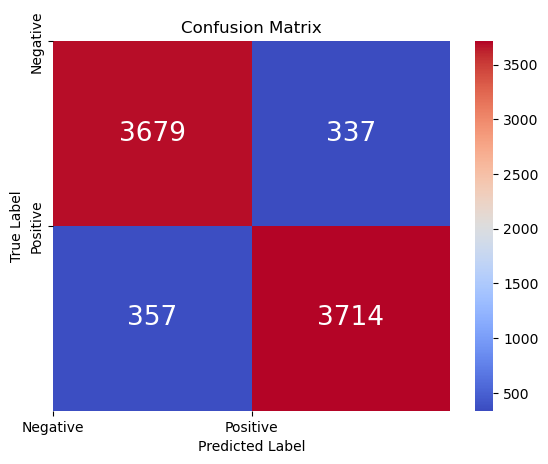

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = model.predict(X_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

# Generate classification report and confusion matrix
class_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and accuracy values from the confusion matrix
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Print classification report and precision/recall/accuracy values
print(class_report)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

# Plot confusion matrix
#plt.imshow(cm, cmap=plt.cm.Blues)
sns.heatmap(cm,annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.title("Confusion Matrix")
#plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], labels=["Negative", "Positive"])
plt.yticks([0, 1], labels=["Negative", "Positive"])
plt.show()